# Introduction to Wavelets

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018 (updated in 2023)    
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

## Contents
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
 * [Objective](#Objective)
 * [Wavelets](#Wavelets)
1. [Stationary vs Non-Stationary Signals](#Stationary-vs-Non-Stationary-Signals)
 * [Stationary Signal](#Stationary-Signal)
 * [Non-Stationary Signal](#Non-Stationary-Signal)
1. [Windowed Fourier Transform](#Windowed-Fourier-Transform)
 * [Uncertainty Principle](#Uncertainty-Principle)
 * [Gabor Transform](#Gabor-Transform)
1. [Wavelets](#Wavelets)
 * [Multiresolution Analysis](#Multiresolution-Analysis)
 * [Wavelet Types](#Wavelet-Types)
 * [Continuous Wavelet Transform](#Continuous-Wavelet-Transform)
 * [Discrete Wavelet Transform](#Discrete-Wavelet-Transform)
 * [Undecimated Wavelet Transform](#Undecimated-Wavelet-Transform)
 * [Starlet Transform](#Starlet-Transform)

## Set-Up

Here we will import a couple of packages that will be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [3]:
# Import the numpy package with the alias np.
import numpy as np           

# Import some tools from scipy.
from scipy.signal import gausspulse

# Import time package.
import time

# Import interaction module
from ipywidgets.widgets import interact

# Import tutorial functions.
from sparsity_tutorial import plot
from sparsity_tutorial.functions import *


## Introduction

### <font color='#007acc'>Objective</font>

The objective of this notebook is to provide a very brief introduction to the concept of wavelets with some practical demonstrations of how they work. To keep things as simple and open a possible I have avoided using packages such as <a href="https://pywavelets.readthedocs.io/en/latest/" target_="blank">PyWavelets</a> or <a href="https://cea-cosmic.github.io/pysap/" target_="blank">PySAP</a> to implement the wavelet transforms. However, after undertanding the basics, these packages can be very useful for practical applications. 



## Stationary vs Non-Stationary Signals

### <font color='#007acc'>Stationary Signal</font>

Stationary signals are those that do not change over time. Take for example the following singal that combines 3 sine waves with different frequencies.

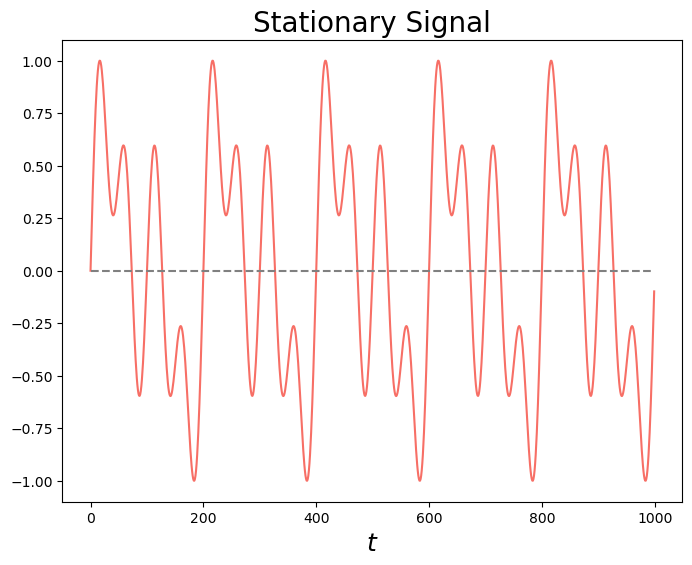

In [4]:
# Set a range of t values
t = np.arange(0, 1, 0.001)

# Define a stationary signal
x_s = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
x_s /= np.max(x_s)

# Plot the signal
plot.line_plot(x_s, ylim=(-1.1, 1.1), xlab='$t$', title='Stationary Signal')

We can clearly see that the pattern produced by the combination of frequencies is periodic. By taking the Fourier transform of this signal we can easily pinpoint the exact frequencies it contains.

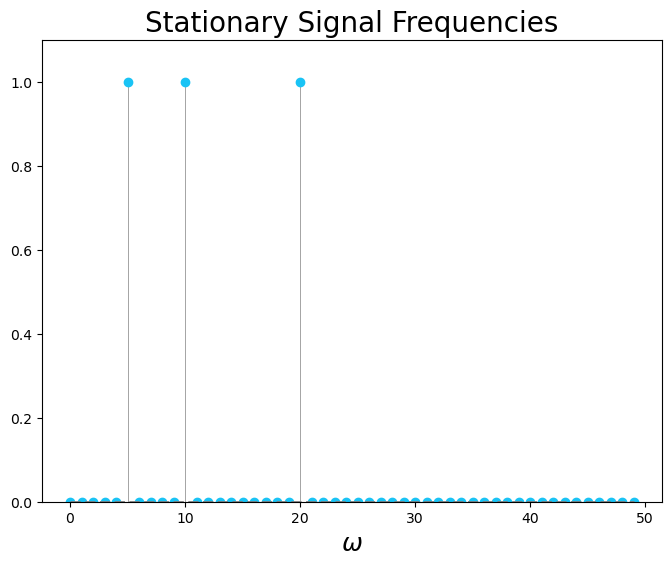

In [5]:
# Calculate the FFT of the signal
x_s_fft = np.abs(fft(x_s))[x_s.size // 2:x_s.size // 2 + 50]
x_s_fft /= np.max(x_s_fft)

# Plot the signal
plot.stem_plot(x_s_fft, ylim=(0.0, 1.1), imag=False, xlab=r'$\omega$', title='Stationary Signal Frequencies')

As expected we get three peaks at the corresponding frequencies. In fact, the frequency information tells us everything we need to know about this signal.


### <font color='#007acc'>Non-Stationary Signal</font>

Non-stationary signals are those that change over time. Let's combine the same 3 sine waves at different time intervals and see what happens.

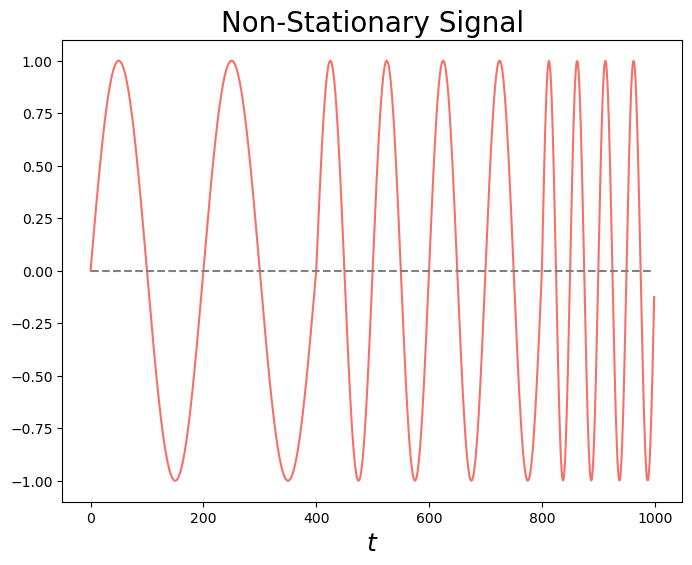

In [6]:
# Define a non-stationary signal
x_n = np.hstack((np.sin(2 * np.pi * 5 * t[:400]), np.sin(2 * np.pi * 10 * t[400:800]), 
                 np.sin(2 * np.pi * 20 * t[800:])))
x_n /= np.max(x_n)

# Plot the signal
plot.line_plot(x_n, ylim=(-1.1, 1.1), xlab='$t$', title='Non-Stationary Signal')

In this example the signal is clearly not periodic. As before we can take the Fourier transform to examine the frequency content.

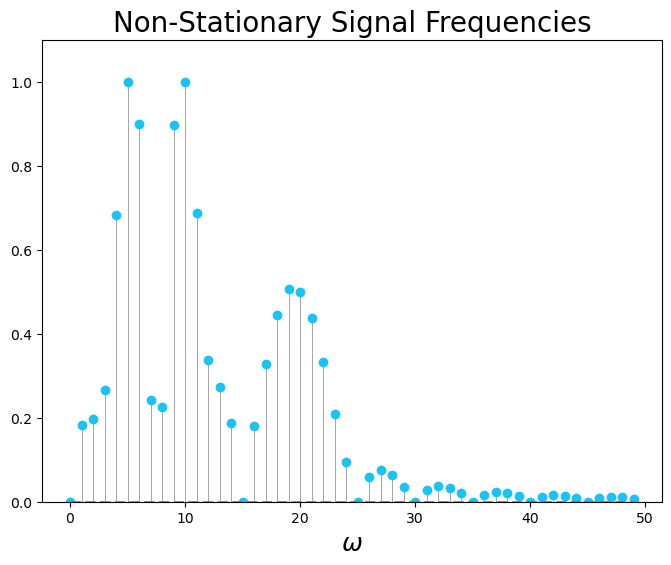

In [7]:
# Calculate the FFT of the signal
x_n_fft = np.abs(fft(x_n))[x_n.size // 2:x_n.size // 2 + 50]
x_n_fft /= np.max(x_n_fft)

# Plot the signal
plot.stem_plot(x_n_fft, ylim=(0.0, 1.1), imag=False, xlab=r'$\omega$', title='Non-Stationary Signal Frequencies')

The frequency space is not as clean as that of the stationary signal due to the sudden change of frequencies, but we can still see wider peaks centred on our original frequencies. For a more realistic signal we would expect something more like this for both cases. The main difference for the non-stationary signal is that even though we can work out the frequencies we don't know when they occurred.

## Windowed Fourier Transform

Most discrete signals, such as the non-stationary time series in the cell below, can be decomposed into a sum of sine and cosine wave with the Discrete Fourier Transform (DFT).

$$F[n] = \frac{1}{N} \sum_{k=0}^{N-1} f[k] e^{2\pi i kn/N}$$

$$f[k] = \sum_{n=0}^{N-1} F[n] e^{-2\pi i kn/N}$$

where $N$ denotes the number of data points, and $n$ and $k$ represent the ordinals in the time and frequency domains respectively.

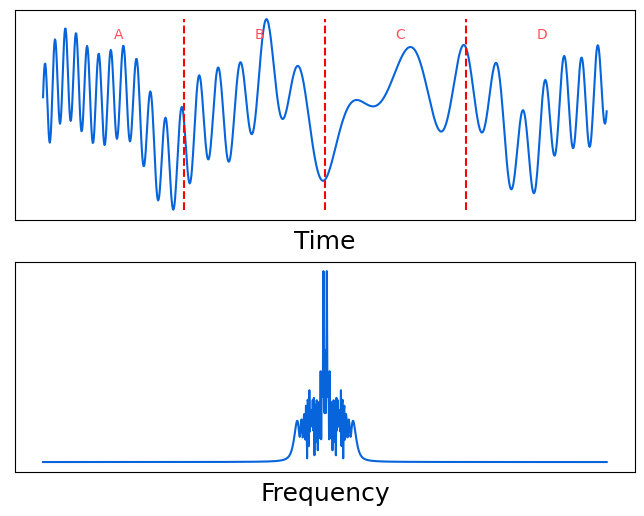

In [8]:
# Define the signal
n = np.linspace(0, 10, 1000, endpoint=False)
Fn = (3 * np.sin(2 * n) + 0.5 * np.tanh(0.5 * (n - 3)) * 0.28 * np.exp(-(-n - 4) **2) + 1.5 * np.sin(5 * n) + 
      4 * np.cos(3 * (n - 6) **2)) / 10 + (n / 20) **3
Fn /= max(abs(Fn))

# Get the Fourier transform of the signal
fk = np.abs(fft(Fn))

# Display signals
plot.wave_plot(n, Fn, fk)

In doing so, however, we lose all of the time information. We can try instead looking at the frequency information contained within smaller time intervals.

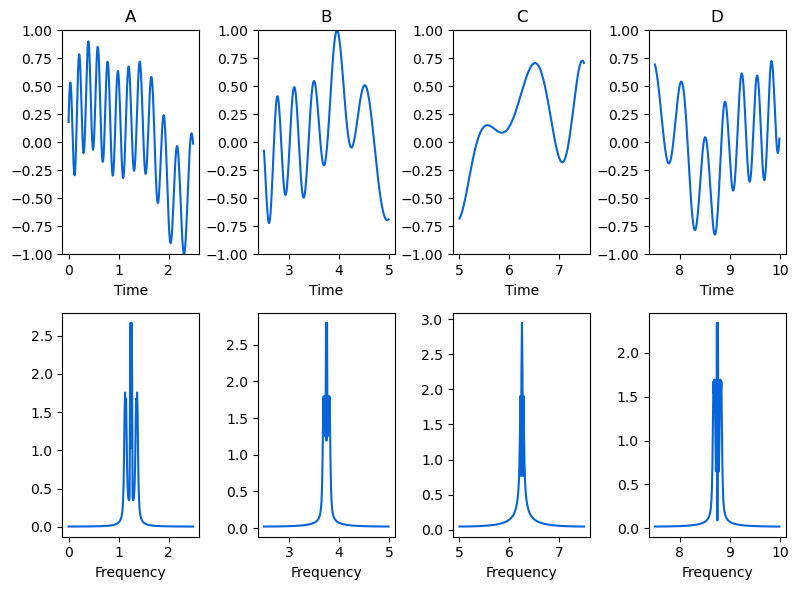

In [9]:
# Slice the signal into four pieces
slices = [slice(i * n.size // 4, (i + 1) * n.size // 4) for i in range(4)]
n_slices = [n[slice_i] for slice_i in slices]
Fn_slices = [Fn[slice_i] for slice_i in slices]
fk_slices = [np.abs(fft(Fn_i)) for Fn_i in Fn_slices]

# Display signals
plot.wave_plot2(n_slices, Fn_slices, fk_slices)

Notice that we can identify different frequencies of the signal contained within the time intervals, but what happens if we make the windows smaller?

### <font color='#007acc'>Uncertainty Principle</font>

The **Heisenberg–Gabor limit**, 

$$\Delta t \Delta \omega \geq \frac{1}{2},$$

an interpretation of the <a href="https://en.wikipedia.org/wiki/Uncertainty_principle#Signal_processing" target_="blank">uncertainty principle</a>, shows that it is not possible to simultaneously sharply localize a signal in both the time domain and frequency domain.

In other words we will always need to make a trade-off between time information and frequency information, but what is the best way to preserve as much of both as possible?

### <font color='#007acc'>Gabor Transform</font>

The <a href="https://en.wikipedia.org/wiki/Gabor_transform" target_="blank">Gabor transform</a> or Short Time Fourier Transform (STFT) can be represented as:

$$f[m, k] = \sum_{n=0}^{N-1} F[n] g[n - m] e^{-2\pi i kn/N}$$

where $g$ is a Gaussian filter localised at $m$

$$g[n] = e^{-\alpha n^2}$$

Effectively this performs a Fourier transform of the signal within a filter that is centred at $m$. 

In [10]:
# Define a Gaussian filter.
def get_filter(m, a):

    return np.exp(-a * (n - m) ** 2)
    return np.exp(-a * (n - m) ** 2)

In [11]:
@interact(pos=(0, 10, 0.5), alpha=(0, 20, 1))
def show_filter(pos=0.0, alpha=1):
    
    # Get localised filter.
    g = get_filter(pos, alpha)

    # Filter the signal.
    Fg = Fn * g

    # Get frequencies of filtered signal.
    Fg_fft = np.abs(fft(Fg))

    # Display.
    plot.filter_plot(n, Fn, g, Fg, Fg_fft)

interactive(children=(FloatSlider(value=0.0, description='pos', max=10.0, step=0.5), IntSlider(value=1, descri…

Try adjusting the filter width and position and see what happens.

Now, to try to preserve some frequency and time information simultaneously we will slide the filter across the whole signal and store the frequencies at a set of time intervals.

In [12]:
@interact(alpha=(0, 100, 10))
def show_tf(alpha=0):

    # Set a range of time intervals.
    intervals = np.arange(0, 10, 0.01)

    # Get the FFT of the filtered signal at each interval.
    w = []
    for m in intervals:
        w.append(np.abs(fft(Fn * get_filter(m, alpha)))[400:600])
    w = np.array(w).T

    # Display
    plot.tf_plot(w)

interactive(children=(IntSlider(value=0, description='alpha', step=10), Output()), _dom_classes=('widget-inter…

Try changing the filter width to see what happens.

While we retain information in both time and frequency domains we also lose resolution. When the window is small we have good time localisation but we can only capture high frequencies. On the other hand, when the window is large we can capture lower frequencies but we have very poor time localisation.

## Wavelets

### <font color='#007acc'>Multiresolution Analysis</font>

One way we can improve upon the Gabor method is using *Multiresolution Analysis (MRA)*. Rather than choosing a fixed window size that will be more localised in either the time or frequency domain, we can instead do the following:

* Start with a small window and extract the highest frequency content of the signal with very good time localisation.
* Then remove these frequencies from the signal.
* Then by enlarging the window by a small amount we can pick out the highest remaining frequencies, which will be lower than those removed, with slighly worse time localisation.
* This process can be continued until the window contains the entire signal which will only retain the lowest frequencies with virtually no time localisation.

### <font color='#007acc'>Wavelet Types</font>

The wavelet function is often represented as follows:

$$\psi_{a,b}(t) = \frac{1}{\sqrt{a}} \psi \Bigg(\frac{t-b}{a} \Bigg)$$

where $a$ defines the wavelet scale and $b$ the shift. $\psi$ is known as the *Mother Wavelet* which must posses certain properties (see *e.g.* [Wikipedia](https://en.wikipedia.org/wiki/Wavelet#Mother_wavelet) for more details). Many different wavelets exist, but we will only discuss a few basic ones.


A couple of essential properties we want any given wavelet to have are the following:

* $\int_{-\infty}^\infty\psi(t)dt = 0$ (*i.e.* equal positive and negative area under the curve)
* $\|\psi(t)\|_2^2 = 1$
* <a href="http://mathworld.wolfram.com/CompactSupport.html" target_="blank">Compact support</a> (*i.e.* signal does not last forever)

**Haar Wavelet**

The Haar wavelet (1910) is a basic step function and is defined as follows:

$$\psi(t) = \begin{cases}1 & 0 \leq t \leq \frac{1}{2} \\ -1 & \frac{1}{2} \leq t \leq 1 \\ 0 & \text{otherwise}\end{cases}$$


In [13]:
# Function to define Haar wavelet.
def haar_wt(t):

    t = np.array([t])
    x = np.zeros(t.size)
    x += np.array((0.0 <= t)[0] * (t < 0.5)[0])
    x -= np.array((0.5 <= t)[0] * (t < 1.0)[0])
    return x

**Mexican Hat Wavelet**

The Mexican Hat (or Ricker) wavelet  is defined as follows:

$$\psi(t) = \frac{2}{\sqrt{3\sigma}\pi^{\frac{1}{4}}}\Bigg(1-\frac{t^2}{\sigma^2}\Bigg)e^{-\frac{t^2}{2\sigma^2}}$$


In [15]:
# Function to define mexican hat wavelet.
def mex_hat_wt(t, sigma=1.0):

    return (2.0 * np.pi ** -0.25 * (3.0 * sigma) ** -0.5 *
            (1 - (t / sigma) ** 2) * np.exp(-t ** 2 / (2.0 * sigma ** 2)))

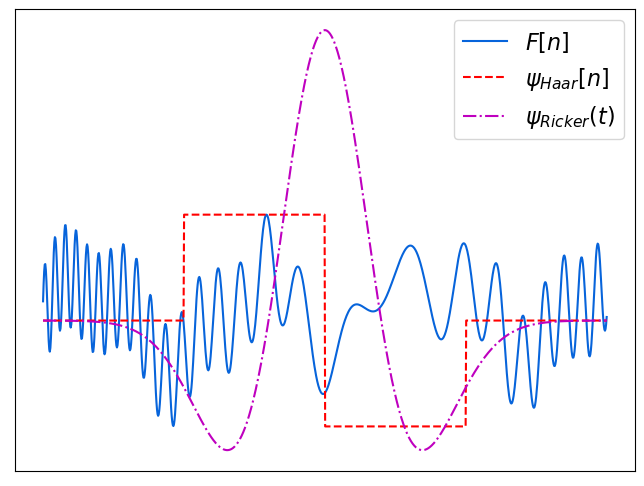

In [16]:
# Display
plot.wavelet_plot(n, Fn, haar_wt(2 * n / np.max(n) - 0.5), mex_hat_wt(n / np.max(n) - 0.5, 0.1))

In general one aims to use the wavelet most suited to the problem at hand.

### <font color='#007acc'>Continuous Wavelet Transform</font>

The <a href="https://en.wikipedia.org/wiki/Continuous_wavelet_transform" target_="blank">Continuous Wavelet Transform (CWT)</a> is used to decompose a signal into wavelets and can be defined as follows:

$$F_{\omega}(a, b) = \frac{1}{|a|^{0.5}}\int_{-\infty}^\infty f(t)\bar{\psi}\Bigg(\frac{t-b}{a}\Bigg)dt$$

We can use this to transform our signal into the wavelet domain using the Mexican Hat wavelet.

In [17]:
# Function to get wavelet scales
def get_scales(a_min, a_max):
    
    J = 12.0 * np.log2(a_max / a_min)
    del_a = (a_max - a_min) / (J - 1)
    return a_min + del_a * np.arange(J)

In [18]:
# Function to perform continuous wavelet transform
def cwt(data, wavelet, scales):
    
    x_ft = fft(data)
    t = np.arange(data.size) - (data.size - 1.0) / 2
    out = []
    for scale in scales:
        w_ft = fft(wavelet(t / scale) * scale ** -0.5)
        out.append(ifft(w_ft * x_ft))
    return np.abs(out)

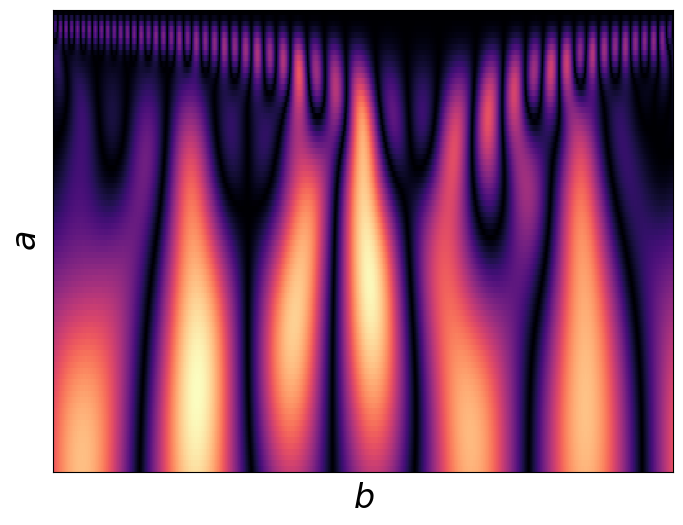

In [19]:
# Set wavelet scales
scales = get_scales(1, 100)

# Wavetlet transform the signal
y = cwt(Fn, mex_hat_wt, scales)

# Display
plot.cwt_plot(y)

As you can see we are able to preserve detailed information regarding the scale and translation of the signal.

### <font color='#007acc'>Discrete Wavelet Transform</font>

The <a href="https://en.wikipedia.org/wiki/Discrete_wavelet_transform" target_="blank">Discrete Wavelet Transform (DWT)</a> uses a discrete set of wavelet scales and translations that removes certain redundancies introduced in the CWT.

$$c_{j+1, l} = \sum h_{k-2l}c_{j,k} = (\bar{h}*c_j)_{2l}$$
$$w_{j+1, l} = \sum g_{k-2l}c_{j,k} = (\bar{g}*c_j)_{2l}$$

This corresponds to consecutively convolving the signal with high and low pass filters with a downsampling at each level. 

<img src="images/dwt.png" width="800">


### <font color='#007acc'>Undecimated Wavelet Transform</font>

The <a href="https://en.wikipedia.org/wiki/Stationary_wavelet_transform" target_="blank">Undecimated Wavelet Transform (UWT)</a> (also called the Stationary Wavelet Transform) removes the downsampling factor to compensate for the translation-invariance in the DWT at the cost of added redundancy.   

<img src="images/uwt.png" width="600">

### <font color='#007acc'>Starlet Transform</font>

Other specialised wavelet transforms exist such as the **Starlet** (or Isotropic Undecimated Wavelet Transform) that
is particularly well suited to astrophysical images, which are generally isotropic (read more <a href="http://jstarck.free.fr/Chapter_Starlet2011.pdf" target_="blank">here</a>).

The starlet transform decomposes an image, $\mathbf{x}$, into a coarse scale, $\mathbf{x}^J$, and wavelet scales, $(\boldsymbol{w}^j)_{1\leq j \leq J}$,

$$\mathbf{x} = \mathbf{x}^{J} + \sum_{j=1}^J \boldsymbol{w}^{j}$$

where the first level ($j = 1$) corresponds to the highest frequencies (*i.e.* the finest scale).

Have a look at the following starlet decomposition of Venus.

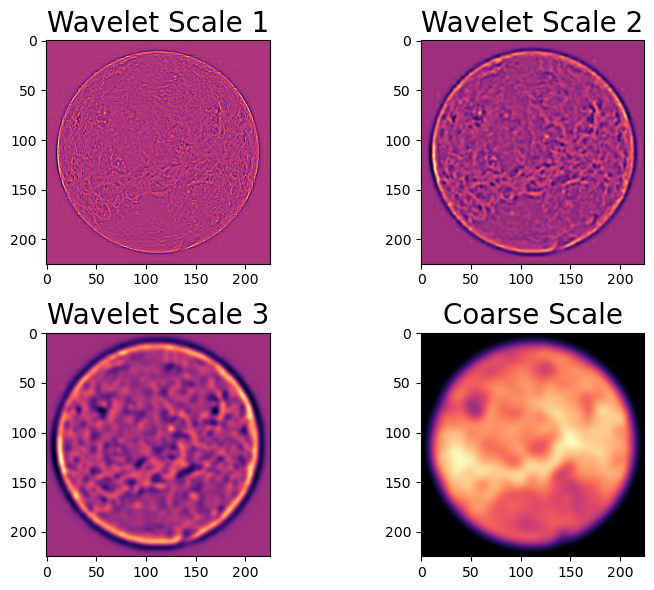

In [20]:
# Load starlet decomposition of Venus.
venus_scales = np.load('data/venus.npy')

# Display the scales.
plot.starlet_display(venus_scales)

Reconstruct the image of venus from the decomposition.

### <font color='#e42d2f'>EXERCISE</font>

In [ ]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Reconstruct the image of Venus.
venus = None

# Display the reconstruction.
if venus is not None:
    plot.display(venus, title='Venus', cmap='magma')

This makes the starlet a useful transform for obtaining sparse representations of astronomical images.

---

## <font color='orange'>Hints</font>

**Starlet Transform**

1. You have just about reached the *sum(m)it* of this tutorial.